## Exp-034 (ULMS BERT)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu Sep 16 08:01:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers pycld2

     |████████████████████████████████| 2.8 MB 8.3 MB/s 
     |████████████████████████████████| 41.4 MB 1.2 MB/s 
     |████████████████████████████████| 3.3 MB 61.1 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 
     |████████████████████████████████| 636 kB 66.2 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834345 sha256=927e4260238a7a3ce95c22dcc3e60fadc8f8b25c104eb2f7165f8246d1035fef
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
input_dir = "/content/drive/MyDrive/07_Competition/signate-471/data/"
output_dir = "/content/drive/MyDrive/07_Competition/signate-471/log/"
submission_dir = "/content/drive/MyDrive/07_Competition/signate-471/submission/"
model_dir = "/content/drive/MyDrive/07_Competition/signate-471/model_bin/"
pred_dir = "/content/drive/MyDrive/07_Competition/signate-471/pred/"

In [5]:
import os
import math
import random
import pandas as pd
import numpy as np
from glob import glob
import gc
gc.enable()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler
from torch.autograd import Variable

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

from transformers import BertConfig, RobertaConfig
from transformers import (get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertModel, RobertaModel
from transformers import AutoConfig, BertConfig, RobertaConfig
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from torch import cuda
import time
import itertools

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import MODEL_FOR_SEQUENCE_CLASSIFICATION_MAPPING
from transformers import get_linear_schedule_with_warmup

from IPython.display import clear_output
from tqdm import tqdm, trange

import re
import nltk
import pycld2 as cld2
from scipy.optimize import minimize, minimize_scalar
import regex
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
class CFG:
  exp = "exp34h"
  seed = 71
  fold = 5
  max_len = 280
  epochs = 1
  lr = 2e-5
  train_batch_size = 16
  valid_batch_size = 32
  model_name = "GanjinZero/UMLSBert_ENG"

CONFIG = CFG()

In [7]:
os.makedirs(model_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(pred_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(output_dir+CONFIG.exp+"/", exist_ok=True)

In [8]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

set_random_seed(CONFIG.seed)

In [9]:
DEVICE = torch.device('cuda') if cuda.is_available() else 'cpu'

In [10]:
def init_logger(log_file=output_dir + CONFIG.exp+ f"/{CONFIG.exp}_train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [11]:
def get_train_data(train):
    # 交差検証 用の番号を振ります。
    Fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

def get_test_data(test):
    return test

In [12]:
class SRWSDataset(Dataset):
  def __init__(self, df, inference_only=False):

    # Berttokenizer
    tokenizer = BertTokenizer.from_pretrained(CONFIG.model_name)

    self.df = df
    self.inference_only = inference_only # "train":False or "test":True
    self.text = self.df["title_abst"].tolist() # text

    if not self.inference_only:
      # ここvalueだけ
      self.target = df["judgement"].values
      
    self.encoded = tokenizer.batch_encode_plus(
        self.text,
        padding = "max_length",
        max_length = CONFIG.max_len,
        truncation = True,
        return_attention_mask=True
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    input_ids = torch.tensor(self.encoded["input_ids"][index])
    attention_mask = torch.tensor(self.encoded["attention_mask"][index])

    # returnをsetかdictで返すかは自由
    if self.inference_only:
      return (input_ids, attention_mask)

    else:
      # ここで、tensor に変更している
      target = torch.tensor(self.target[index]).float()
      return (input_ids, attention_mask, target)


In [13]:
class SRWSBertModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.config = BertConfig.from_pretrained(CFG.model_name)
    self.config.update({"output_hidden_states": True})
    self.config.hidden_dropout_prob = 0
    self.config.attention_probs_dropout_prob = 0
    self.bert = BertModel.from_pretrained(CONFIG.model_name, config=self.config)
    self.regressor = nn.Linear(self.config.hidden_size*4, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask) 
    sequence_output = torch.cat([output["hidden_states"][-1*i][:,0] for i in range(1, 4+1)], dim=1)
    bert_output = self.regressor(sequence_output)
    bert_output = self.sigmoid(bert_output).squeeze()

    return bert_output

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [15]:
# 学習
def train_fn(model, train_loader, optimizer, epoch, loss_function, scheduler=None):
  start = end = time.time()
  losses = AverageMeter()
  model.train()

  for batch_num, (input_ids, attention_mask, target) in enumerate(train_loader):
    optimizer.zero_grad()

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    pred = model(input_ids, attention_mask)

    # Loss算出
    #print(pred)
    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)
    loss.backward()

    optimizer.step()

    if scheduler:
      scheduler.step()

    if batch_num % 100 == 0 or batch_num == (len(train_loader) -1):
      print(
            f"Epoch: [{epoch + 1}][{batch_num}/{len(train_loader)}] "
            f"Elapsed {timeSince(start, float(batch_num + 1) / len(train_loader)):s} "
            f"Loss: {losses.avg:.4f} "
            )
      
  return losses.avg

def valid_fn(valid_loader, model, loss_function):
  start = end = time.time()
  losses = AverageMeter()

  model.eval()
  preds = []

  for batch_num, (input_ids, attention_mask, target) in enumerate(valid_loader):
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    # compare loss
    with torch.no_grad():
      pred = model(input_ids, attention_mask)

    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)

    # スコア追加
    preds.append(pred.to("cpu").numpy())

    if batch_num % 100 == 0 or batch_num == (len(valid_loader) - 1):
      print(
          f"EVAL: [{batch_num}/{len(valid_loader)}]"
          f"Elapsed {timeSince(start, float(batch_num+1) / len(valid_loader)):s}"
          f"Loss: {losses.avg:.4f}"
      )
  predictions = np.concatenate(preds)

  return losses.avg, predictions

# 予測
def inference():
    predictions = []

    test_dataset = SRWSDataset(test,  inference_only=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG.valid_batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    for fold in range(CONFIG.fold):
        LOGGER.info(f"========== model: {CONFIG.model_name} fold: {fold} inference ==========")
        model = SRWSBertModel()
        model.to(DEVICE)
        model.load_state_dict(torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")["model"])
        model.eval()
        preds = []
        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            with torch.no_grad():
                y_preds = model(input_ids, attention_mask)
            preds.append(y_preds.to("cpu").numpy())
        preds = np.concatenate(preds)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

In [16]:
# 最適化（使ってない）
# https://signate.jp/competitions/471/discussions/tf-roberta-base-baseline-cv08949-lb08734

def opt_fbeta_threshold(y_true, y_pred):
  """fbeta score計算時のthresholdを最適化"""
  def opt_(x):
    return -fbeta_score(y_true, y_pred >= x, beta=7)
  result = minimize(opt_, x0=np.array([0.02]), method='Powell')
  best_threshold = result['x'].item()
  return best_threshold

In [17]:
def get_optimizer_grouped_parameters(model):
    model_type = 'bert'
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                       if 'lstm' in n
                       or 'cnn' in n
                       or 'regressor' in n],
            "weight_decay": 0.0,
            "lr": 1e-3,
        },
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = CONFIG.lr
    for layer in layers:
        lr *= 0.95
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.1,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [31]:
# LOOP
def train_loop(train, fold):
  LOGGER.info(f"========== fold: {fold} training ==========")

  # ====================================================
  # Data Loader
  # ====================================================
  trn_idx = train[train["fold"] != fold].index
  val_idx = train[train["fold"] == fold].index

  train_folds = train.loc[trn_idx].reset_index(drop=True)
  valid_folds = train.loc[val_idx].reset_index(drop=True)

  train_dataset = SRWSDataset(train_folds)
  valid_dataset = SRWSDataset(valid_folds)

  train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.train_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True, # https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
        drop_last=True,
  )
  valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG.valid_batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
  )

  # ====================================================
  # Model
  # ====================================================
  model = SRWSBertModel()
  model.to(DEVICE)

  optimizer_parameters = get_optimizer_grouped_parameters(model)

  #optimizer = AdamW(model.parameters(), lr=CONFIG.lr)
  optimizer = AdamW(optimizer_parameters, lr=CONFIG.lr, weight_decay=0.1)

  # Loss_function
  loss_function = FocalLoss()

  # ====================================================
  # LOOP
  # ====================================================

  best_score = -1
  best_loss = np.inf
  best_borders=[]

  # 学習
  for epoch in range(CONFIG.epochs):
    start_time = time.time()

    # train
    avg_loss = train_fn(model, train_loader, optimizer, epoch, loss_function)

    # valid
    avg_val_loss, preds = valid_fn(valid_loader, model,loss_function)
    valid_labels = valid_folds["judgement"].values

    # border最適化
    border_m = opt_fbeta_threshold(valid_labels, preds)
    best_borders.append(border_m)

    # score
    score = fbeta_score(valid_labels, np.where(preds < border_m, 0, 1), beta=7.0)

    elapsed = time.time() - start_time
    LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
    )
    LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

    if score > best_score:
      best_score = score
      LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} ")
      torch.save(
                {"model": model.state_dict(), "preds": preds}, model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth"
      ) # scibertでの変更
  check_point = torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")

  valid_folds["preds"] = check_point["preds"]

  return valid_folds,best_borders

In [21]:
def get_result(result_df):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_threshold))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_threshold, 0, 1), beta=7.0)
    print("Score：" + str(score))
    LOGGER.info(f"Score: {score:<.5f}")

# inference用に、best_thresholdを出力するようにする関数
def get_result_for_cv(result_df,best_border):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    #best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_border))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_border, 0, 1), beta=7.0)
    LOGGER.info(f"Score: {score:<.5f}")

    return score

def mean_best_border(*best_borders):
    best_border = np.mean(best_borders)
    print("Best_Threshold：" + str(best_border))
    LOGGER.info(f"Best_Border: {best_border:<.8f}")

    return best_border

In [22]:
def clean_stopword(text):
  stopwords = nltk.corpus.stopwords.words('english')
  list_x = text.split()
  res = []
  for w in list_x:
    if w not in stopwords:
      res.append(w)
  return ' '.join(res)

def clean_puncts(x):
  # 化学式とかがあるから '-'は削除しないほうがいいか？

  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
            '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
            '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
            '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
            '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '（', '）', '～',
            '➡', '％', '⇒', '▶', '「', '➄', '➆',  '➊', '➋', '➌', '➍', '⓪', '①', '②', '③', '④', '⑤', '⑰', '❶', '❷', '❸', '❹', '❺', '❻', '❼', '❽',  
            '＝', '※', '㈱', '､', '△', '℮', 'ⅼ', '‐', '｣', '┝', '↳', '◉', '／', '＋', '○',
            '【', '】', '✅', '☑', '➤', 'ﾞ', '↳', '〶', '☛', '｢', '⁺', '『', '≫',
            'Â©', '<sub>','Aﾎｲ', 'ﾎｲ', "ﾃｩ"
          ] 
  # 文字化け対応はここで対応するしかない？
  
  for punct in puncts:
    x = x.replace(punct, '')
  return x

def _pre_preprocess(x):
  return str(x).lower() 

def rm_num(x, use_num=True):
  numbers = ["0","1","2","3","4","5","6","7","8","9","０","１","２","３","４","５","６","７","８","９"]
  x = re.sub('[0-9]{5,}', '', x)
  x = re.sub('[0-9]{4}', '', x)
  x = re.sub('[0-9]{3}', '', x)
  x = re.sub('[0-9]{2}', '', x)    
  for i in numbers:
    x = x.replace(str(i), '')        
  return x

def convert_mojibake(text):
  text = text.encode("shift-jis").decode("utf-8", errors="ignore")
  return text

def remove_double(text):
  text = text.replace("  ", " ")
  return text

def preprocess_text(text):
  #text = _pre_preprocess(text)
  #text = clean_stopword(text)
  text = clean_puncts(text)
  text = rm_num(text)
  text = remove_double(text)

  return text

def split_copyright(text):
  if "Copyright" in text:
    text = text.split('Copyright')[0]
    return text
  else:
    return text


In [23]:
pd.set_option("display.max_colwidth", 50)
train = pd.read_csv(input_dir + "train.csv")
test = pd.read_csv(input_dir + "test.csv")
sub = pd.read_csv(input_dir + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

In [24]:
# ラベル変更
# https://signate.jp/competitions/471/discussions/20210816152356-59

train.loc[train["id"]==2488, "judgement"] = 0
train.loc[train["id"]==7708, "judgement"] = 0

In [25]:
train = get_train_data(train)
train.head()

,id,title,abstract,judgement,fold
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1


In [26]:
train["title_abst"] = train["title"] + train["abstract"]
train["title_abst"].fillna(train["title"], inplace=True)

test["title_abst"] = test["title"] + test["abstract"]
test["title_abst"].fillna(test["title"], inplace=True)

train.head()

,id,title,abstract,judgement,fold,title_abst
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4,One-year age changes in MRI brain volumes in o...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3,Supportive CSF biomarker evidence to enhance t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2,Occurrence of basal ganglia germ cell tumors w...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1,Prolonged shedding of SARS-CoV-2 in an elderly...


In [27]:
# preprocess
train["title_abst"] = train["title_abst"].apply(lambda x: preprocess_text(x))
test["title_abst"] = test["title_abst"].apply(lambda x: preprocess_text(x))

# titleの単語数が3以下のものは除外してみる
train["title_word_len"] = train["title"].str.split(" ").str.len()
train = train[train["title_word_len"]>3]

# titleが他言語の場合は除外
train["title_lang"] = train["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
train = train[(train["title_lang"]=="en")|(train["title_lang"]=="un")]

# copyright以降は削除したい
train["title_abst"] = train["title_abst"].apply(lambda x: split_copyright(x))
test["title_abst"] = test["title_abst"].apply(lambda x: split_copyright(x))

In [28]:
train

,id,title,abstract,judgement,fold,title_abst,title_word_len,title_lang
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4,Oneyear age changes in MRI brain volumes in ol...,10,en
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3,Supportive CSF biomarker evidence to enhance t...,23,en
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2,Occurrence of basal ganglia germ cell tumors w...,10,en
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...,13,en
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1,Prolonged shedding of SARSCoV in an elderly li...,16,en
...,...,...,...,...,...,...,...,...
27140,27140,The amyloidogenic pathway of amyloid precursor...,Amyloid beta-protein (A beta) is the main cons...,0,1,The amyloidogenic pathway of amyloid precursor...,15,en
27141,27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,0,4,Technologic developments in radiotherapy and s...,7,en
27142,27142,Novel screening cascade identifies MKK4 as key...,Phosphorylation of Tau at serine 422 promotes ...,0,2,Novel screening cascade identifies MKK as key ...,13,en
27143,27143,Visualization of the gall bladder on F-18 FDOP...,The ability to label dihydroxyphenylalanine (D...,0,2,Visualization of the gall bladder on F FDOPA P...,13,en


In [32]:
# Training
#border = len(train[train["judgement"] == 1]) / len(train["judgement"]) # 0.023245467689912133
#border = border * 0.6

mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df.csv", index=False)

========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [1][0/1345] Elapsed 0m 0s (remain 21m 41s) Loss: 0.1669 
Epoch: [1][100/1345] Elapsed 1m 22s (remain 17m 0s) Loss: 0.0421 
Epoch: [1][200/1345] Elapsed 2m 48s (remain 15m 59s) Loss: 0.0333 
Epoch: [1][300/1345] Elapsed 4m 14s (remain 14m 43s) Loss: 0.0285 
Epoch: [1][400/1345] Elapsed 5m 40s (remain 13m 22s) Loss: 0.0266 
Epoch: [1][500/1345] Elapsed 7m 6s (remain 11m 58s) Loss: 0.0259 
Epoch: [1][600/1345] Elapsed 8m 32s (remain 10m 34s) Loss: 0.0251 
Epoch: [1][700/1345] Elapsed 9m 58s (remain 9m 9s) Loss: 0.0237 
Epoch: [1][800/1345] Elapsed 11m 24s (remain 7m 44s) Loss: 0.0233 
Epoch: [1][900/1345] Elapsed 12m 50s (remain 6m 19s) Loss: 0.0221 
Epoch: [1][1000/1345] Elapsed 14m 16s (remain 4m 54s) Loss: 0.0212 
Epoch: [1][1100/1345] Elapsed 15m 42s (remain 3m 28s) Loss: 0.0204 
Epoch: [1][1200/1345] Elapsed 17m 8s (remain 2m 3s) Loss: 0.0197 
Epoch: [1][1300/1345] Elapsed 18m 34s (remain 0m 37s) Loss: 0.0190 
Epoch: [1][1344/1345] Elapsed 19m 12s (remain 0m 0s) Loss: 0.0190 


Epoch 1 - avg_train_loss: 0.0190  avg_val_loss: 0.0115  time: 1251s
Epoch 1 - Score: 0.9048723897911833
Epoch 1 - Save Best Score: 0.9049 
========== fold: 0 result ==========
Best_Border: 0.18273359
========== fold: 1 training ==========


Best_Threshold：0.1827335872499114


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [1][0/1346] Elapsed 0m 1s (remain 22m 49s) Loss: 0.0667 
Epoch: [1][100/1346] Elapsed 1m 27s (remain 17m 59s) Loss: 0.0532 
Epoch: [1][200/1346] Elapsed 2m 53s (remain 16m 28s) Loss: 0.0371 
Epoch: [1][300/1346] Elapsed 4m 19s (remain 15m 0s) Loss: 0.0351 
Epoch: [1][400/1346] Elapsed 5m 45s (remain 13m 34s) Loss: 0.0321 
Epoch: [1][500/1346] Elapsed 7m 11s (remain 12m 7s) Loss: 0.0292 
Epoch: [1][600/1346] Elapsed 8m 37s (remain 10m 41s) Loss: 0.0271 
Epoch: [1][700/1346] Elapsed 10m 3s (remain 9m 15s) Loss: 0.0259 
Epoch: [1][800/1346] Elapsed 11m 29s (remain 7m 49s) Loss: 0.0245 
Epoch: [1][900/1346] Elapsed 12m 55s (remain 6m 23s) Loss: 0.0233 
Epoch: [1][1000/1346] Elapsed 14m 21s (remain 4m 56s) Loss: 0.0225 
Epoch: [1][1100/1346] Elapsed 15m 47s (remain 3m 30s) Loss: 0.0220 
Epoch: [1][1200/1346] Elapsed 17m 13s (remain 2m 4s) Loss: 0.0213 
Epoch: [1][1300/1346] Elapsed 18m 39s (remain 0m 38s) Loss: 0.0206 
Epoch: [1][1345/1346] Elapsed 19m 18s (remain 0m 0s) Loss: 0.0205

Epoch 1 - avg_train_loss: 0.0205  avg_val_loss: 0.0139  time: 1256s
Epoch 1 - Score: 0.9234828496042217
Epoch 1 - Save Best Score: 0.9235 
========== fold: 1 result ==========
Best_Border: 0.29194271
========== fold: 2 training ==========


Best_Threshold：0.2919427092892258


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [1][0/1345] Elapsed 0m 1s (remain 23m 3s) Loss: 0.1793 
Epoch: [1][100/1345] Elapsed 1m 27s (remain 17m 59s) Loss: 0.0316 
Epoch: [1][200/1345] Elapsed 2m 53s (remain 16m 29s) Loss: 0.0285 
Epoch: [1][300/1345] Elapsed 4m 19s (remain 15m 1s) Loss: 0.0253 
Epoch: [1][400/1345] Elapsed 5m 45s (remain 13m 34s) Loss: 0.0242 
Epoch: [1][500/1345] Elapsed 7m 11s (remain 12m 7s) Loss: 0.0223 
Epoch: [1][600/1345] Elapsed 8m 37s (remain 10m 40s) Loss: 0.0209 
Epoch: [1][700/1345] Elapsed 10m 3s (remain 9m 14s) Loss: 0.0203 
Epoch: [1][800/1345] Elapsed 11m 29s (remain 7m 48s) Loss: 0.0202 
Epoch: [1][900/1345] Elapsed 12m 55s (remain 6m 22s) Loss: 0.0198 
Epoch: [1][1000/1345] Elapsed 14m 21s (remain 4m 56s) Loss: 0.0193 
Epoch: [1][1100/1345] Elapsed 15m 47s (remain 3m 30s) Loss: 0.0191 
Epoch: [1][1200/1345] Elapsed 17m 13s (remain 2m 3s) Loss: 0.0190 
Epoch: [1][1300/1345] Elapsed 18m 40s (remain 0m 37s) Loss: 0.0184 
Epoch: [1][1344/1345] Elapsed 19m 17s (remain 0m 0s) Loss: 0.0181 

Epoch 1 - avg_train_loss: 0.0181  avg_val_loss: 0.0283  time: 1256s
Epoch 1 - Score: 0.8578052550231839
Epoch 1 - Save Best Score: 0.8578 
========== fold: 2 result ==========
Best_Border: 0.08688382
========== fold: 3 training ==========


Best_Threshold：0.08688382368546414


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [1][0/1346] Elapsed 0m 1s (remain 22m 59s) Loss: 0.1598 
Epoch: [1][100/1346] Elapsed 1m 27s (remain 17m 59s) Loss: 0.0291 
Epoch: [1][200/1346] Elapsed 2m 53s (remain 16m 29s) Loss: 0.0266 
Epoch: [1][300/1346] Elapsed 4m 19s (remain 15m 1s) Loss: 0.0242 
Epoch: [1][400/1346] Elapsed 5m 45s (remain 13m 34s) Loss: 0.0223 
Epoch: [1][500/1346] Elapsed 7m 11s (remain 12m 8s) Loss: 0.0218 
Epoch: [1][600/1346] Elapsed 8m 37s (remain 10m 41s) Loss: 0.0216 
Epoch: [1][700/1346] Elapsed 10m 3s (remain 9m 15s) Loss: 0.0206 
Epoch: [1][800/1346] Elapsed 11m 29s (remain 7m 49s) Loss: 0.0204 
Epoch: [1][900/1346] Elapsed 12m 55s (remain 6m 23s) Loss: 0.0200 
Epoch: [1][1000/1346] Elapsed 14m 21s (remain 4m 56s) Loss: 0.0203 
Epoch: [1][1100/1346] Elapsed 15m 47s (remain 3m 30s) Loss: 0.0196 
Epoch: [1][1200/1346] Elapsed 17m 12s (remain 2m 4s) Loss: 0.0190 
Epoch: [1][1300/1346] Elapsed 18m 38s (remain 0m 38s) Loss: 0.0186 
Epoch: [1][1345/1346] Elapsed 19m 17s (remain 0m 0s) Loss: 0.0186

Epoch 1 - avg_train_loss: 0.0186  avg_val_loss: 0.0105  time: 1255s
Epoch 1 - Score: 0.9357263383954595
Epoch 1 - Save Best Score: 0.9357 
========== fold: 3 result ==========
Best_Border: 0.11903147
========== fold: 4 training ==========


Best_Threshold：0.11903147361777279


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [1][0/1346] Elapsed 0m 1s (remain 22m 49s) Loss: 1.2260 
Epoch: [1][100/1346] Elapsed 1m 27s (remain 17m 56s) Loss: 0.0537 
Epoch: [1][200/1346] Elapsed 2m 53s (remain 16m 28s) Loss: 0.0369 
Epoch: [1][300/1346] Elapsed 4m 19s (remain 15m 0s) Loss: 0.0308 
Epoch: [1][400/1346] Elapsed 5m 45s (remain 13m 34s) Loss: 0.0293 
Epoch: [1][500/1346] Elapsed 7m 11s (remain 12m 8s) Loss: 0.0255 
Epoch: [1][600/1346] Elapsed 8m 37s (remain 10m 41s) Loss: 0.0246 
Epoch: [1][700/1346] Elapsed 10m 3s (remain 9m 15s) Loss: 0.0226 
Epoch: [1][800/1346] Elapsed 11m 29s (remain 7m 49s) Loss: 0.0218 
Epoch: [1][900/1346] Elapsed 12m 55s (remain 6m 23s) Loss: 0.0208 
Epoch: [1][1000/1346] Elapsed 14m 21s (remain 4m 56s) Loss: 0.0200 
Epoch: [1][1100/1346] Elapsed 15m 47s (remain 3m 30s) Loss: 0.0196 
Epoch: [1][1200/1346] Elapsed 17m 13s (remain 2m 4s) Loss: 0.0188 
Epoch: [1][1300/1346] Elapsed 18m 39s (remain 0m 38s) Loss: 0.0192 
Epoch: [1][1345/1346] Elapsed 19m 17s (remain 0m 0s) Loss: 0.0191

Epoch 1 - avg_train_loss: 0.0191  avg_val_loss: 0.0146  time: 1256s
Epoch 1 - Score: 0.8425686959161985
Epoch 1 - Save Best Score: 0.8426 
========== fold: 4 result ==========
Best_Border: 0.12040806
========== CV ==========
Best_Border: 0.16019993
Score: 0.83500


Best_Threshold：0.12040805648543096
Best_Threshold：0.16019993006556102
Best_Threshold：0.16019993006556102


In [33]:
best_border

0.16019993006556102

In [34]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission.csv", index=False, header=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
100%|██████████| 1277/1277 [12:13<00:00,  1.74it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [12:19<00:00,  1.73it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [12:17<00:00,  1.73it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [12:16<00:00,  1.73it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 in

In [39]:
pred_df=pd.read_csv(pred_dir +CONFIG.exp + "/pred_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


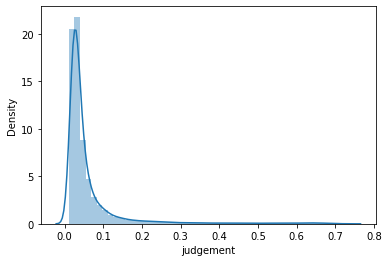

In [40]:
import seaborn as sns
sns.distplot(pred_df["judgement"])

In [37]:
oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


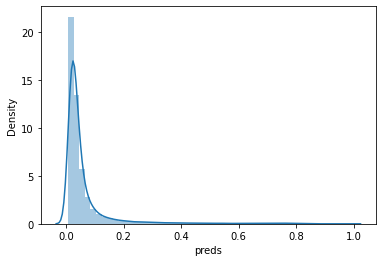

In [38]:
import seaborn as sns
sns.distplot(oof_df["preds"])